In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter as dtf
import matplotlib.dates as mtd

import numpy as np
import pandas as pd
import os
import datetime as dt
from datetime import date, timedelta

from flask import Flask
from flask import jsonify
from matplotlib.dates import DateFormatter as dtf


# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect = True)

# reflect the tables

In [5]:
# We can view all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [6]:
cols_measure = inspector.get_columns('measurement')

for col in cols_measure:
    print (col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
cols_stxn = inspector.get_columns('station')

for col in cols_stxn:
    print (col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

#session = Session(bind=engine)
#data = session.query(measurement)
#session.query(measurement)

In [25]:
measurement_sql = engine.execute('SELECT * FROM measurement ORDER BY date DESC;').fetchall()
#measurement_sql

In [27]:
station_sql = engine.execute('SELECT * FROM station').fetchall()
# station_sql

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
#this is the first and last date
day_one_str = session.query(measurement.date).order_by(measurement.date).first()
#day_one
last_day_str = session.query(measurement.date).order_by(measurement.date.desc()).first()
#last_day

In [12]:
#one year from last date...
#since the date is a string, we need to use the strptime function
last_date = dt.datetime.strptime(*last_day_str, '%Y-%m-%d')
#last_date

ein_jahr = last_date - dt.timedelta(days=365)

#ein_jahr_str = dt.datetime.strftime(ein_jahr,'%Y-%m-%d')
#ein_jahr
#ein_jahr_str

In [13]:
#Query and panda dataframe, sort index
ein_jahr_frag = session.query(measurement.date, measurement.prcp)\
                .filter(measurement.date >= ein_jahr)\
                .filter(measurement.prcp.isnot(None))\
                .order_by(measurement.date).all()

ein_jahr_df = pd.DataFrame(ein_jahr_frag, columns =['date', 'prcp'])
#ein_jahr_df.head()
#ein_jahr_df['date'] = pd.to_datetime(ein_jahr_df['date']) ##is this needed?

ein_jahr_df.set_index('date', inplace=True)
#ein_jahr_df.head(30)

ein_jahr_df.sort_index(inplace=True)

In [14]:
#let's check for any null values
#ein_jahr_df.isnull().values.any()
#ein_jahr_df.info()

ein_jahr_df.groupby(['date']).sum()

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


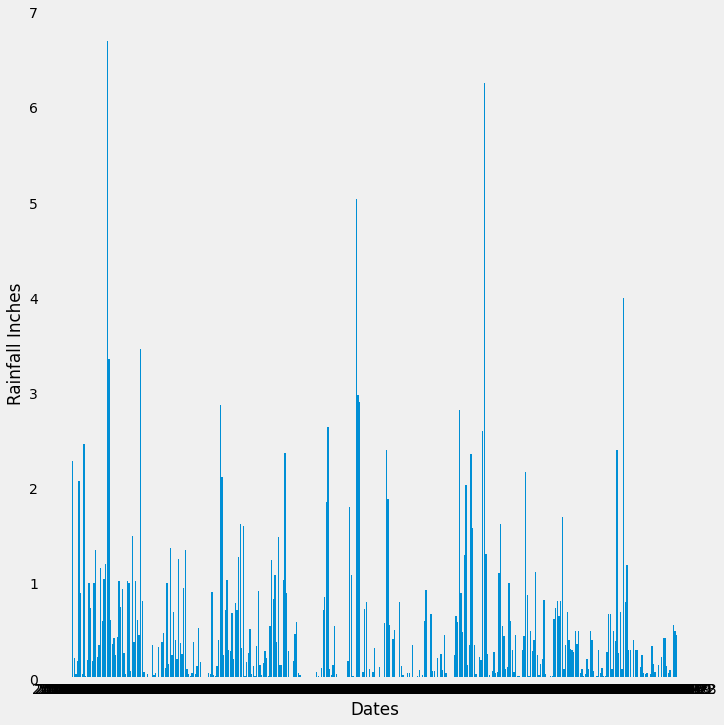

In [15]:
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))

# xmin_date = ein_jahr_df.index.min()
# xmax_date = ein_jahr_df.index.max()
# plt.xlim(xmin_date, xmax_date)
plt.grid()
ax.bar(ein_jahr_df.index, ein_jahr_df['prcp'])
plt.style.use('fivethirtyeight')
plt.tight_layout()
#plt.xticks(rotation=90)

dates = dtf('%Y-%m-%m')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(dates)
# ax.xaxis.set_major_locator(mtd.WeekdayLocator(interval=6))


plt.xlabel('Dates')
plt.ylabel('Rainfall Inches')

plt.savefig(os.path.join('Resources','Precipitation.png'), dpi=100)
plt.show()


### PLEASE HELP!! Why doesn't this work??


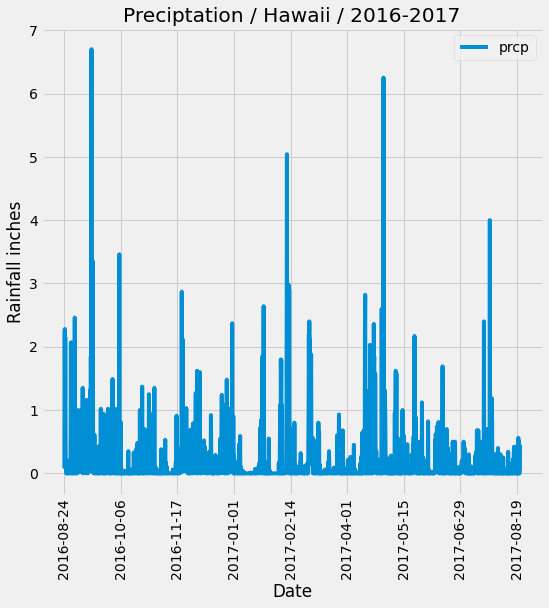

In [16]:
ein_jahr_df.plot(figsize=(8,8), rot=90)
plt.style.use('fivethirtyeight')
plt.title('Preciptation / Hawaii / 2016-2017')
plt.xlabel('Date')
plt.ylabel('Rainfall inches')
plt.savefig(os.path.join('Resources','Precipitation2.png'), dpi=100)
plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ein_jahr_df.describe()  ##is that what you wanted?? 

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
measure = session.query(measurement.id, measurement.station).all()
stxn = session.query(station.id, station.station, station.name).all()

In [19]:
# Design a query to show how many stations are available in this dataset?
stxn_count = session.query(func.count(station.station)).scalar()
stxn_count

9

In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

act_stxn_select = [measurement.station, func.count(measurement.station), station.name]

act_stxn = session.query(*act_stxn_select).filter(station.station == measurement.station)\
                .group_by(measurement.station).order_by(func.count(measurement.station)\
                .desc()).all()

act_stxn

[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00519397', 2724, 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 2709, 'KANEOHE 838.1, HI US'),
 ('USC00519523', 2669, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2612, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 2202, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1979, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 1372, 'PEARL CITY, HI US'),
 ('USC00518838', 511, 'UPPER WAHIAWA 874.3, HI US')]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_act_stxn = act_stxn[0][0]

In [51]:
#min temp / most active station
min_temp = session.query(func.min(measurement.tobs))\
                .filter(measurement.station == most_act_stxn).all()

min_temp

[(54.0)]

In [52]:
#max temp / most active station
max_temp = session.query(func.max(measurement.tobs))\
                .filter(measurement.station == most_act_stxn).all()
max_temp

[(85.0)]

In [53]:
#avg temp / most active station
avg_temp = session.query(func.avg(measurement.tobs))\
                .filter(measurement.station == most_act_stxn).all()
avg_temp

[(71.66378066378067)]

In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

max_obs_data = session.query(measurement.tobs).filter(measurement.station == most_act_stxn)\
                .filter(measurement.date >=ein_jahr).all()

max_obs = list(np.ravel(max_obs_data))
#max_obs

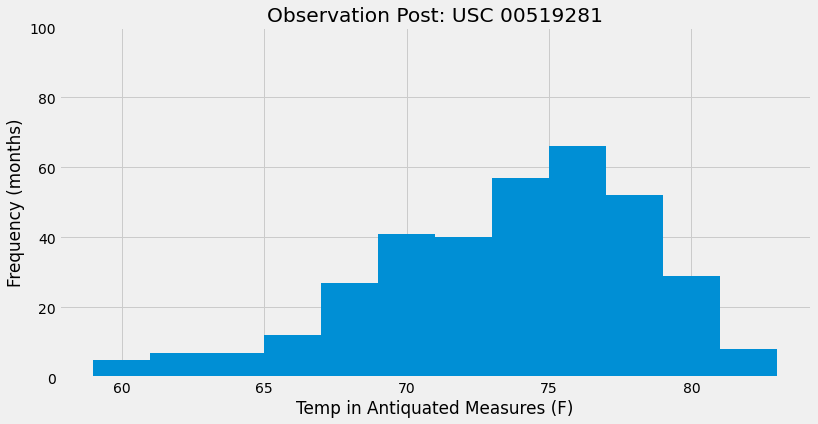

In [59]:
plt.figure(figsize = (12,6))
plt.hist(max_obs, bins = 12)
plt.xlabel('Temp in Antiquated Measures (F)')
plt.ylabel('Frequency (months)')
plt.title('Observation Post: USC 00519281')
plt.ylim(0,100)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
